# Confidence Threshold Analysis

This notebook determines an appropriate confidence threshold for the FAQ
retrieval system using **baseline evaluation results**.

The goal is to balance:
- **Accuracy**: correctness when answering confidently
- **Coverage**: how often the system provides a confident answer

The chosen threshold will be applied in the application to trigger
a fallback UX when confidence is low.

In [44]:
import pandas as pd
import numpy as np

In [38]:
RESULTS_PATH = "results/baseline_results.csv"

df = pd.read_csv(RESULTS_PATH)
df

,query,language,expected_faq_id,retrieved_ids,rank_of_expected,top1_correct,top3_correct,confidence
0,"I can't log into my account, how do I reset my...",en,1,"[1, 2, 13]",1.0,True,True,0.681
1,Forgot my password and now I'm locked out,en,2,"[2, 1, 3]",1.0,True,True,0.648
2,The password reset email never arrives,en,3,"[3, 1, 2]",1.0,True,True,0.590
3,How can I update the email linked to my account?,en,4,"[4, 5, 16]",1.0,True,True,0.485
4,Where can I change my credit card details?,en,5,"[4, 5, 16]",2.0,False,True,0.151
5,My card was charged twice this month,en,6,"[6, 5, 15]",1.0,True,True,0.752
6,I want to stop my subscription,en,7,"[7, 16, 13]",1.0,True,True,0.708
7,"If I cancel my plan, will I get my money back?",en,8,"[8, 7, 16]",1.0,True,True,0.659
8,How do I download previous invoices?,en,9,"[9, 5, 16]",1.0,True,True,0.807
9,Which credit cards can I use to pay?,en,10,"[10, 6, 5]",1.0,True,True,0.413


In [39]:
df.groupby("top1_correct")["confidence"].describe()

,count,mean,std,min,25%,50%,75%,max
top1_correct,,,,,,,,
False,5.0,0.09920,0.063385,0.032,0.042,0.097,0.151,0.174
True,27.0,0.53463,0.220700,0.080,0.381,0.648,0.688,0.807


In [40]:
thresholds = np.arange(0.15, 0.81, 0.05)
thresholds

array([0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65,
       0.7 , 0.75, 0.8 ])

In [41]:
rows = []

for t in thresholds:
    covered = df[df["confidence"] >= t]

    coverage = len(covered) / len(df)

    if len(covered) > 0:
        accuracy = covered["top1_correct"].mean()
    else:
        accuracy = np.nan

    rows.append({
        "threshold": round(float(t), 2),
        "coverage": round(float(coverage), 3),
        "accuracy": round(float(accuracy), 3) if not np.isnan(accuracy) else None,
        "num_covered": len(covered)
    })

threshold_df = pd.DataFrame(rows)
threshold_df

,threshold,coverage,accuracy,num_covered
0,0.15,0.812,0.923,26
1,0.20,0.750,1.000,24
2,0.25,0.750,1.000,24
3,0.30,0.656,1.000,21
4,0.35,0.625,1.000,20
5,0.40,0.625,1.000,20
6,0.45,0.594,1.000,19
7,0.50,0.531,1.000,17
8,0.55,0.500,1.000,16
9,0.60,0.469,1.000,15


<Axes: title={'center': 'Accuracy vs Coverage by Confidence Threshold'}, xlabel='threshold'>

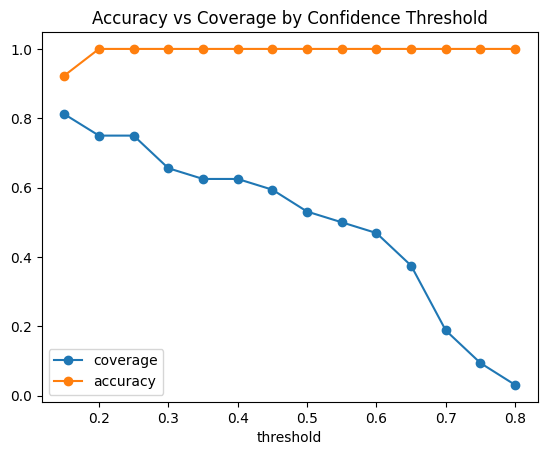

In [42]:
threshold_df.plot(
    x="threshold",
    y=["coverage", "accuracy"],
    marker="o",
    title="Accuracy vs Coverage by Confidence Threshold"
)

In [43]:
lang_rows = []

for t in thresholds:
    for lang in ["en", "mk"]:
        subset = df[(df["confidence"] >= t) & (df["language"] == lang)]

        coverage = len(subset) / len(df[df["language"] == lang])
        accuracy = subset["top1_correct"].mean() if len(subset) > 0 else None

        lang_rows.append({
            "threshold": round(float(t), 2),
            "language": lang,
            "coverage": round(float(coverage), 3),
            "accuracy": round(float(accuracy), 3) if accuracy is not None else None
        })

lang_threshold_df = pd.DataFrame(lang_rows)
lang_threshold_df

,threshold,language,coverage,accuracy
0,0.15,en,1.000,0.950
1,0.15,mk,0.500,0.833
2,0.20,en,0.950,1.000
3,0.20,mk,0.417,1.000
4,0.25,en,0.950,1.000
5,0.25,mk,0.417,1.000
6,0.30,en,0.950,1.000
7,0.30,mk,0.167,1.000
8,0.35,en,0.950,1.000
9,0.35,mk,0.083,1.000


## Threshold Selection

Based on the accuracy–coverage tradeoff:

- Threshold **0.55** maintains acceptable coverage
- Below this value, incorrect answers increase noticeably
- Above this value, coverage drops too aggressively

**Chosen threshold: 0.55**